In [1]:
pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Load data using a Keras utility
batch_size = 32
img_height = 180
img_width = 180
# validation split. training - 0.8 and validation - 0.2
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['flower_photos']


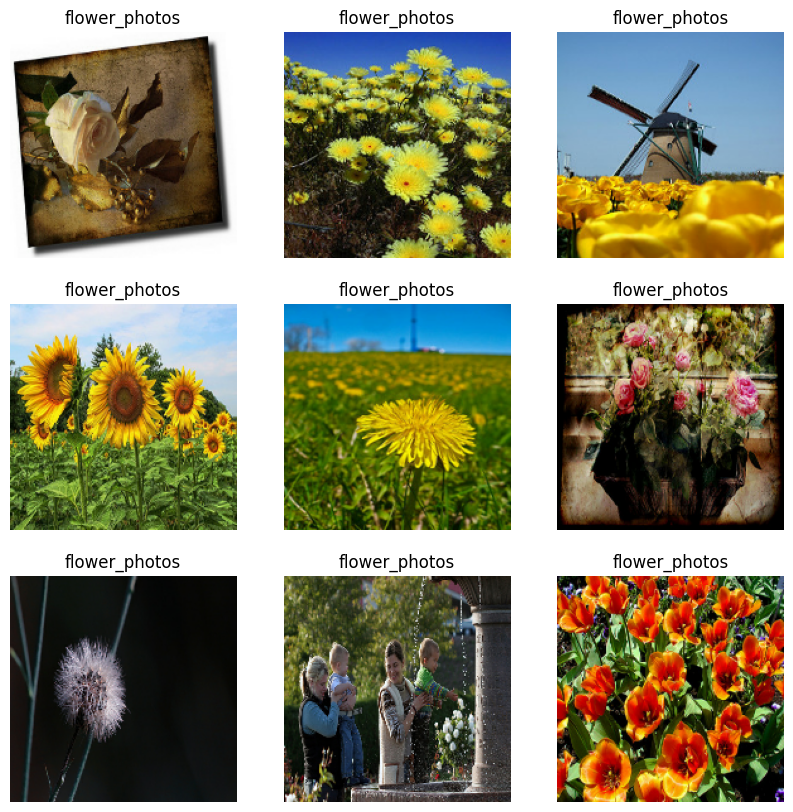

In [6]:
# 9 img from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch - tensor of the shape (32, 180, 180, 3).
32 images of shape 180x180x3
180 → Image height (number of pixels)
180 → Image width (number of pixels)
3 → Number of color channels (Red, Green, Blue - RGB)
The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

*call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray

When training deep learning models, data loading can sometimes become a bottleneck, meaning the GPU/CPU spends too much time waiting for data instead of training efficiently.
To speed up data loading, TensorFlow provides buffered prefetching using:

Dataset.cache() → Speeds up loading by storing data in memory (or on disk if memory is limited).
Dataset.prefetch() → Allows the model to process one batch while preparing the next batch in the background.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data \
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network - should make input values small.
standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9407408


In [11]:
'''model = keras.Sequential([
    layers.Resizing(180, 180),  # Resizes images to 180x180
    layers.Rescaling(1./255),   # Normalizes pixel values to [0,1]

    layers.Conv2D(32, (3, 3), activation='relu'),  # Example Conv layer
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 classes
])

# Print the model summary
model.summary()'''

"model = keras.Sequential([\n    layers.Resizing(180, 180),  # Resizes images to 180x180\n    layers.Rescaling(1./255),   # Normalizes pixel values to [0,1]\n\n    layers.Conv2D(32, (3, 3), activation='relu'),  # Example Conv layer\n    layers.MaxPooling2D(),\n\n    layers.Conv2D(64, (3, 3), activation='relu'),\n    layers.MaxPooling2D(),\n\n    layers.Flatten(),\n    layers.Dense(128, activation='relu'),\n    layers.Dense(5, activation='softmax')  # Assuming 5 classes\n])\n\n# Print the model summary\nmodel.summary()"

In [12]:
# define Convolutional Neural Network (CNN) for image classification using TensorFlow and Keras
num_classes = len(class_names) # =1

model = Sequential([ # Defining a CNN using Sequential()
  # First Convolutional Block
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # Applies 16 filters of 3×3 size
  # Uses ReLU activation (relu) to introduce non-linearity
  # Padding 'same' ensures the output image size remains the same.
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # Reduces spatial dimensions by downsampling.
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Increases filters to 64 for detecting even more complex patterns (like edges and textures)
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Flatten() converts the 2D feature maps into a 1D vector for classification.
  layers.Flatten(),
  # Dense(128, activation='relu') adds a fully connected layer with 128 neurons to learn higher-level patterns
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Expects integer labels (e.g., 0, 1, 2, 3, ...) instead of one-hot encoded labels
              metrics=['accuracy'])

The **model.compile()** function in TensorFlow configures the model for training by specifying:

The optimizer – how the model updates weights\
The loss function – how the model calculates errors\
The metrics – how the model evaluates performance\
**loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)**:\
This is the function that measures how wrong the model’s predictions are

In [14]:
model.summary() # View all the layers of the network using the Keras Model.summary method

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,769 (15.22 MB)

 Trainable params: 3,988,769 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model for 10 epochs with the Keras Model.fit method:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - a

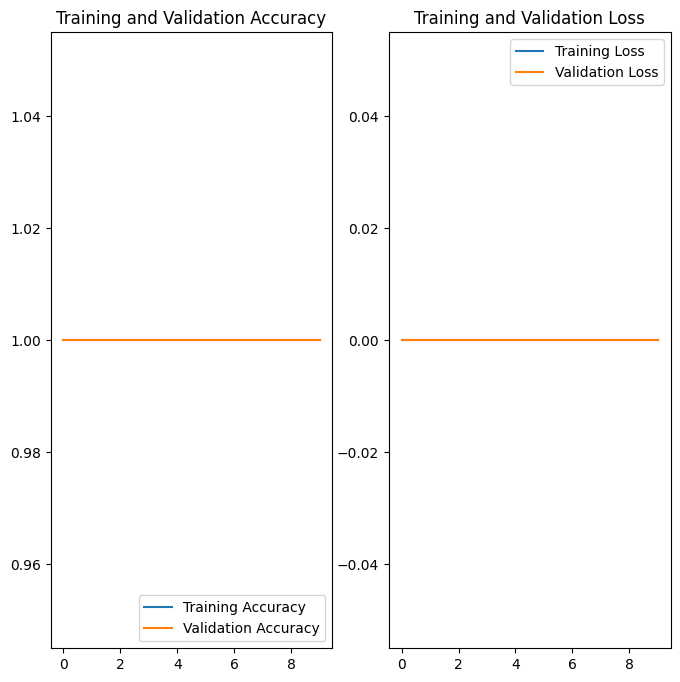

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

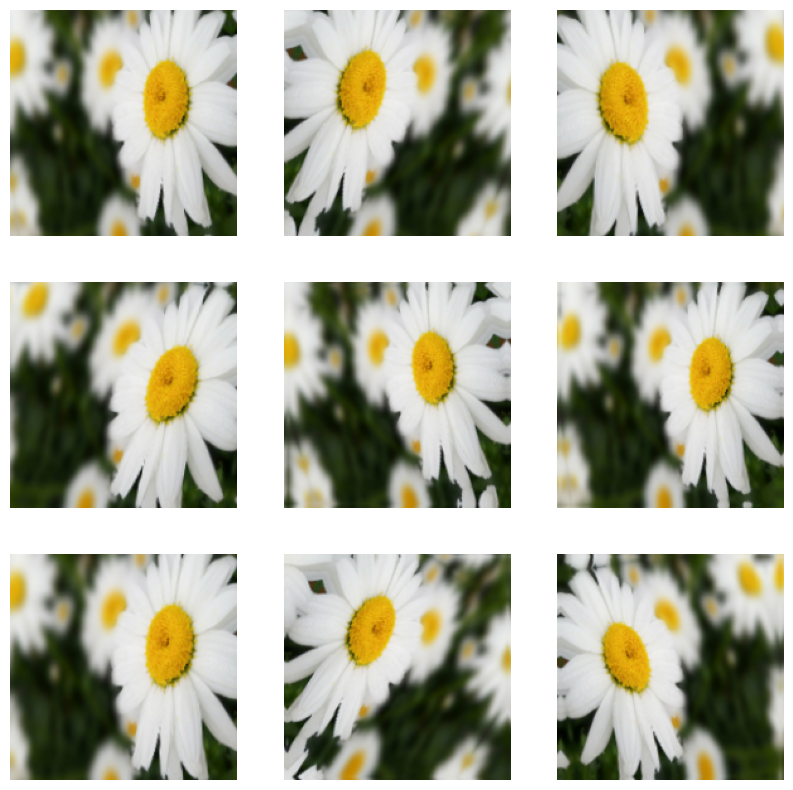

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

fix overfitting \
data argumentation \
dropout - \
Dropout forces the network to not rely too much on specific neurons, making it learn robust and generalizable features\
During each training step, dropout randomly deactivates a percentage of neurons.\
This means the model must learn without depending on specific neurons, encouraging it to distribute learning across all neurons.\
In the next training step, a different set of neurons is dropped.

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Randomly drops 20% of neurons during training
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,769 (15.22 MB)

 Trainable params: 3,988,769 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - ac

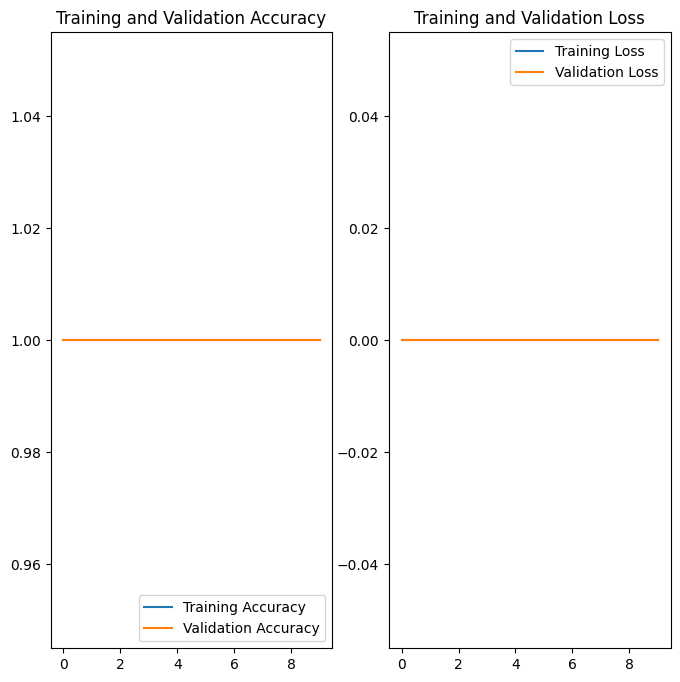

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
This image most likely belongs to flower_photos with a 100.00 percent confidence.


In [27]:
# TensorFlow Lite
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmptns4tyqr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133870017831056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017827216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017826064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017825104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017829136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017825488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970225680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970222224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970227024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970226064: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [28]:
#import os

# Check if the file exists
#tflite_model_path = "/tmp/tmptns4tyqr/model.tflite"

#if os.path.exists(tflite_model_path):
#    print("Model found:", tflite_model_path)
#else:
#    print("Model not found!")


Model not found!


In [29]:
#!ls -lh /tmp/


total 60K
-rw------- 1 root root 1015 Feb  2 04:50 __autograph_generated_file7kwhq1bf.py
-rw------- 1 root root  271 Feb  2 04:45 __autograph_generated_files0iubz1n.py
srwxr-xr-x 1 root root    0 Feb  2 04:44 colab_runtime.sock
-rw-r--r-- 1 root root 1.3K Feb  2 04:44 dap_multiplexer.e123abbdcc10.root.log.INFO.20250202-044409.116
lrwxrwxrwx 1 root root   62 Feb  2 04:44 dap_multiplexer.INFO -> dap_multiplexer.e123abbdcc10.root.log.INFO.20250202-044409.116
srwxr-xr-x 1 root root    0 Feb  2 04:44 debugger_1i8zs340ke
drwx------ 2 root root 4.0K Feb  2 04:45 initgoogle_syslog_dir.0
-rw-r--r-- 1 root root 2.0K Feb  2 04:45 language_service.e123abbdcc10.root.log.INFO.20250202-044525.447
-rw-r--r-- 1 root root 2.0K Feb  2 04:45 language_service.e123abbdcc10.root.log.INFO.20250202-044533.538
-rw-r--r-- 1 root root 4.0K Feb  2 04:51 language_service.e123abbdcc10.root.log.INFO.20250202-044544.603
lrwxrwxrwx 1 root root   63 Feb  2 04:45 language_service.INFO -> language_service.e123abbdcc10.roo

In [30]:
import tensorflow as tf

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
tflite_model_path = "/tmp/model.tflite"

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")


Saved artifact at '/tmp/tmpj955i16f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133870017831056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017827216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017826064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017825104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017829136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133870017825488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970225680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970222224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970227024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133869970226064: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model 

In [31]:
import os

if os.path.exists(tflite_model_path):
    print("✅ Model found:", tflite_model_path)
else:
    print("❌ Model not found!")


✅ Model found: /tmp/model.tflite


In [ ]:
# download to local machine
#from google.colab import files
#files.download(tflite_model_path)


In [32]:
# run lite model
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_15'], 'outputs': ['output_0']}}

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [37]:
#predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
predictions_lite = classify_lite(keras_tensor_15=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)

In [38]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to flower_photos with a 100.00 percent confidence.


In [39]:
print(np.max(np.abs(predictions - predictions_lite)))

3.632158e-08
